In [1]:
# Import Packages
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import os
import netCDF4 as nc
from datetime import datetime
import dask.array
import dask


# Import Data
solar_radiation_path = '/g/data/rt52/era5/single-levels/monthly-averaged/msdrswrf/'
wind_u_component_path = '/g/data/rt52/era5/single-levels/monthly-averaged/10u/'
wind_v_component_path = '/g/data/rt52/era5/single-levels/monthly-averaged/10v/'
runoff_path = '/g/data/zz93/era5-land/monthly-averaged/ro'


# Function to load datasets and select Australia region
def load_yearly_data_aus(path, variable, years, lat_range, lon_range):
    datasets = []
    for year in years:
        try:
            year_path = os.path.join(path, str(year))
            ds = xr.open_mfdataset(os.path.join(year_path, '*.nc'), combine='by_coords')[variable]
            ds_aus = ds.sel(latitude=lat_range, longitude=lon_range)
            datasets.append(ds_aus)  
        except FileNotFoundError:
            print(f"Data for {year} in {path} is missing or corrupted.")
    return datasets


# Time period selected
years_range = range(1959, 2021)

# Latitude and longitude of Australia
lat_range = slice(-10, -44)  # Latitude range
lon_range = slice(112, 154)  # Longitude range

# Load datasets with Australia region selected
aus_solar_radiation_datasets = load_yearly_data_aus(solar_radiation_path, 'msdrswrf', years_range, lat_range, lon_range)
aus_wind_u_datasets = load_yearly_data_aus(wind_u_component_path, 'u10', years_range, lat_range, lon_range)
aus_wind_v_datasets = load_yearly_data_aus(wind_v_component_path, 'v10', years_range, lat_range, lon_range)
aus_runoff_datasets = load_yearly_data_aus(runoff_path, 'ro', years_range, lat_range, lon_range)

# Calculate Wind Speed
wind_speed_datasets_aus = [np.sqrt(u**2 + v**2) for u, v in zip(aus_wind_u_datasets, aus_wind_v_datasets)]

In [2]:
# Concatenate datasets for each variable across time to form a single dataset without filling NaNs
def concatenate_datasets(datasets):
    return xr.concat(datasets, dim='time').chunk({'time': -1})


# Concatenate all data sets along time axis
combined_solar = concatenate_datasets(aus_solar_radiation_datasets)
combined_wind = concatenate_datasets(wind_speed_datasets_aus)
combined_runoff = concatenate_datasets(aus_runoff_datasets)


# Resampled runoff data to ensure consistent spatial resolution
runoff_resampled = combined_runoff.interp(
    latitude=combined_solar.latitude.values, 
    longitude=combined_solar.longitude.values, 
    method='linear'  
)


# Calculate 25th Percentile for Each Variable
wind_speed_25th = combined_wind.quantile(0.25, dim='time', skipna=True)
solar_25th = combined_solar.quantile(0.25, dim='time', skipna=True)
runoff_25th = runoff_resampled.quantile(0.25, dim='time', skipna=True)


# Identify timestamps where each variable is below the 25th percentile
solar_below_25th = combined_solar < solar_25th
wind_below_25th = combined_wind < wind_speed_25th
runoff_below_25th = runoff_resampled < runoff_25th

In [3]:
ds = xr.Dataset({
    'solar_below_25th': solar_below_25th,
    'wind_below_25th': wind_below_25th,
    'runoff_below_25th': runoff_below_25th 
}, coords={
    'time': combined_solar['time'],  
    'latitude': combined_solar['latitude'], 
    'longitude': combined_solar['longitude'] 
})

### 1. Identify Compound Events

In [30]:
# Identifying compound drought events (all three conditions are True)
compound_events = ds['solar_below_25th'] & ds['wind_below_25th'] & ds['runoff_below_25th']

# Count number of True values across time to find how often all conditions are met
compound_event_count = compound_events.sum(dim='time')

### 2. Plot Frequency of Compound Events

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


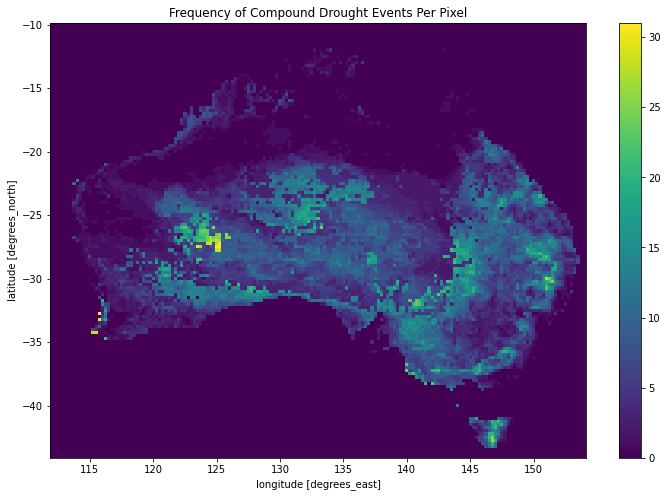

In [31]:
# Plotting
plt.figure(figsize=(12, 8))
compound_event_count.plot()
plt.title('Frequency of Compound Drought Events Per Pixel')
plt.show()

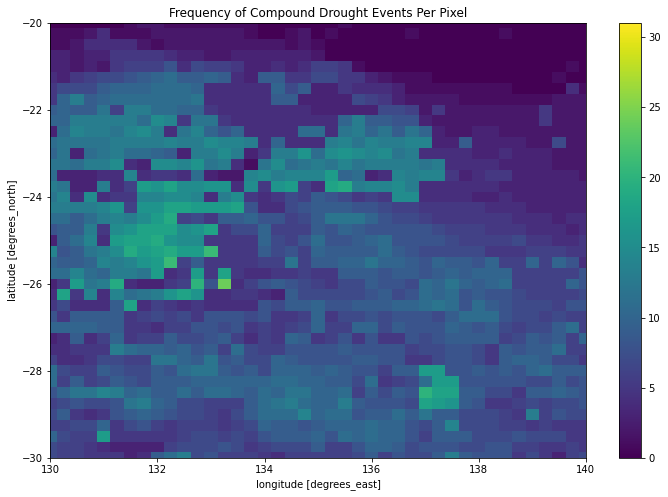

In [6]:
# zoom out
plt.figure(figsize=(12, 8))  
compound_event_count.plot()
plt.title('Frequency of Compound Drought Events Per Pixel')
plt.xlim(130, 140)  
plt.ylim(-30, -20)  
plt.show()

## Plot for each pair of droughts

### 1) solar and wind droughts

In [22]:
# Identifying compound drought events (solar and wind droughts are True)
drought_solar_wind = ds['solar_below_25th'] & ds['wind_below_25th']

# Count number of True values across time to find how often all conditions are met
drought_solar_wind_count = drought_solar_wind.sum(dim='time')

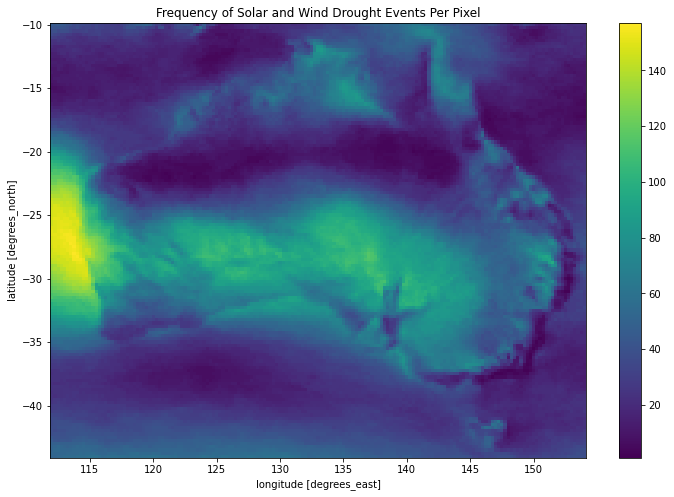

In [23]:
# Plotting
plt.figure(figsize=(12, 8))
drought_solar_wind_count.plot()
plt.title('Frequency of Solar and Wind Drought Events Per Pixel')
plt.show()

### 2) solar and hydro droughts

In [26]:
# Identifying compound drought events (solar and hydro droughts are True)
drought_solar_runoff = ds['solar_below_25th'] & ds['runoff_below_25th']

# Count number of True values across time to find how often all conditions are met
drought_solar_runoff_count = drought_solar_runoff.sum(dim='time')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


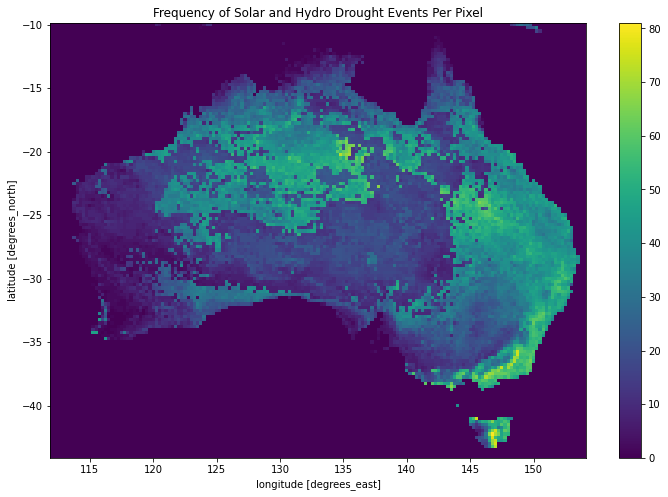

In [27]:
# Plotting
plt.figure(figsize=(12, 8))
drought_solar_runoff_count.plot()
plt.title('Frequency of Solar and Hydro Drought Events Per Pixel')
plt.show()

### 3) wind and hydro droughts

In [32]:
# Identifying compound drought events (wind and hydro droughts are True)
drought_wind_runoff = ds['wind_below_25th'] & ds['runoff_below_25th']

# Count number of True values across time to find how often all conditions are met
drought_wind_runoff_count = drought_wind_runoff.sum(dim='time')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


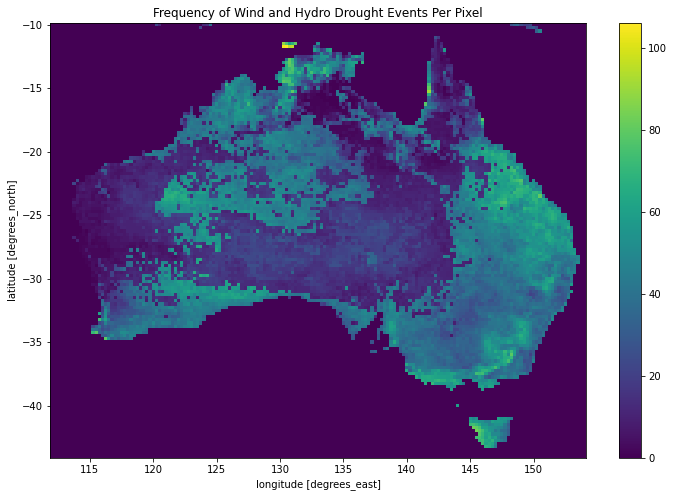

In [33]:
# Plotting
plt.figure(figsize=(12, 8))
drought_wind_runoff_count.plot()
plt.title('Frequency of Wind and Hydro Drought Events Per Pixel')
plt.show()

### 3.1 Analyze Seasonality of Frequency (1959-2021)

In [7]:
# Group by month to see seasonality
compound_events = compound_events.compute().fillna(0)
monthly_compound_events = compound_events.groupby('time.month').sum(dim='time')

# Calculate the average number of events per month
monthly_avg_events = monthly_compound_events.mean(dim=['latitude', 'longitude'])

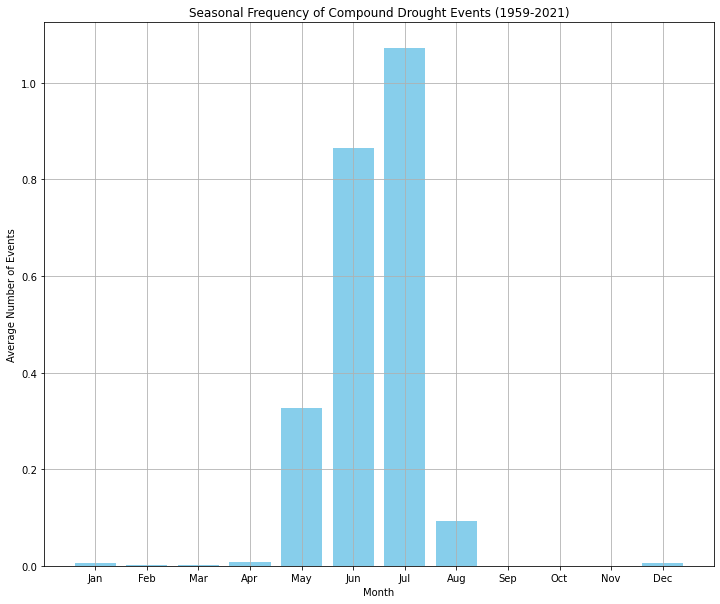

In [8]:
# Plotting the seasonal frequency of compound events
plt.figure(figsize=(12, 10))
months = np.arange(1, 13)
plt.bar(months, monthly_avg_events, color='skyblue')
plt.title('Seasonal Frequency of Compound Drought Events (1959-2021)')
plt.xlabel('Month')
plt.ylabel('Average Number of Events')
plt.xticks(ticks=months, labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()

In [9]:
# # Plotting the seasonal frequency of compound events
# plt.figure(figsize=(12, 10))
# monthly_avg_events.plot(marker='o', linestyle='-')  
# plt.title('Seasonal Frequency of Compound Drought Events (1959-2021)')
# plt.xlabel('Month')
# plt.ylabel('Average Number of Events')
# plt.grid(True)
# plt.xticks(ticks=np.arange(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']) 
# plt.show()

### 3.2 Total numbers of compound droughts occur in each month (1959-2021)

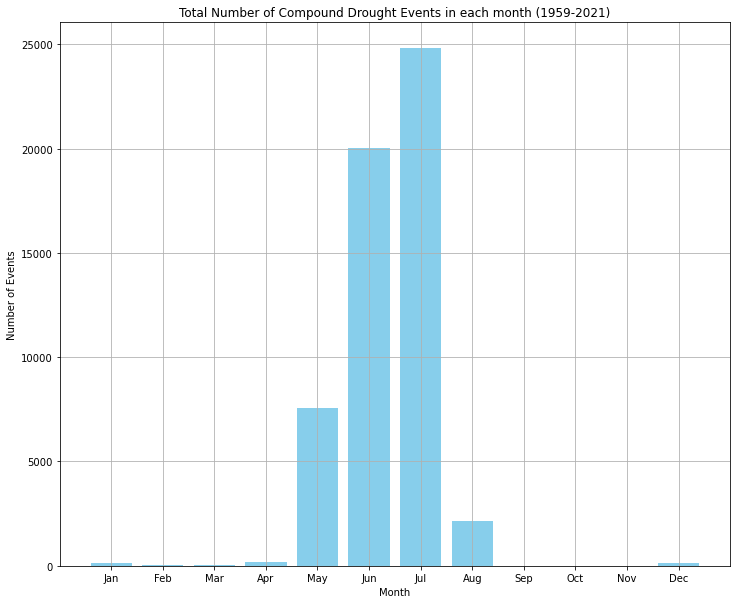

In [10]:
# Calculate the total number of events per month
monthly_event_counts = monthly_compound_events.sum(dim=['latitude', 'longitude'])

# Plotting bar chart to show the number of events per month
plt.figure(figsize=(12, 10))
months = np.arange(1, 13)
plt.bar(months, monthly_event_counts, color='skyblue')
plt.title('Total Number of Compound Drought Events in each month (1959-2021)')
plt.xlabel('Month')
plt.ylabel('Number of Events')
plt.xticks(ticks=months, labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()


### 4. Calculating the average percentile rank of three kinds droughts

In [11]:
# Function of calculating the percentile rank for each time step for each variable
def calculate_percentile_ranks(variable_data):
    if isinstance(variable_data.data, dask.array.Array):
        variable_data = variable_data.load()
    return variable_data.rank(dim='time', pct=True)

# Calculate percentile ranks for each variable
wind_percentiles = calculate_percentile_ranks(combined_wind)
solar_percentiles = calculate_percentile_ranks(combined_solar)
runoff_percentiles = calculate_percentile_ranks(runoff_resampled)

# Calculate the average percentile rank for severity of conditions
severity_index = (wind_percentiles + solar_percentiles + runoff_percentiles) / 3

# Identify severe compound drought events where severity is below 25th percentile
severe_compound_events = severity_index.where((solar_below_25th & wind_below_25th & runoff_below_25th), drop=True)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)


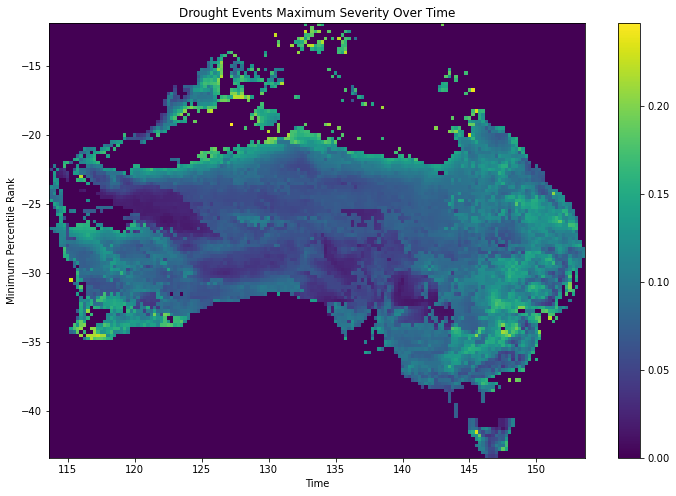

In [12]:
# Calculate the mean severity of drought events across the entire time period
# mean_severity = severe_compound_events.mean(dim=‘time’).fillna(0)
# Calculate the lowest percentile ranking (maximum severity) of drought events over the entire time period
max_severity = severe_compound_events.min(dim='time').fillna(0)

# Plotting
plt.figure(figsize=(12, 8))
max_severity.plot()
plt.title('Drought Events Maximum Severity Over Time')
plt.ylabel('Minimum Percentile Rank')
plt.xlabel('Time')
plt.show()

### 5. Calculate average different droughts values in AU below the 25th percentile

#### 5.1 The average radiation value of solar radiation below the 25th percentile

In [13]:
# Calculate the mean solar radiation values where solar radiation is below the 25th percentile
solar_mean_below_25th = combined_solar.where(ds['solar_below_25th']).mean(dim='time', skipna=True)

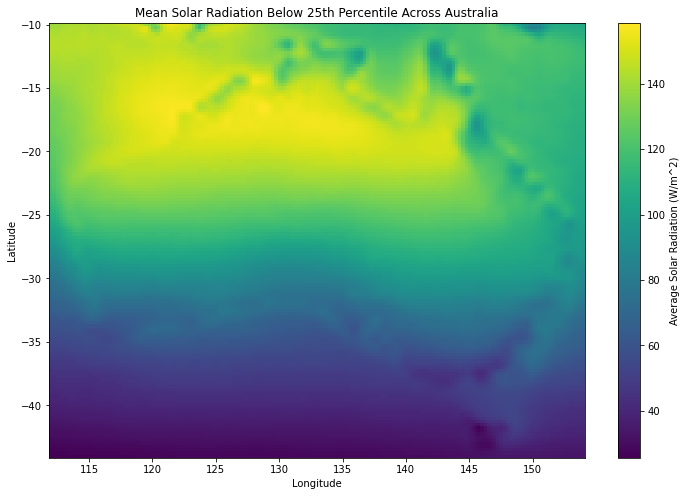

In [14]:
# Plot the mean solar radiation values where solar radiation is below the 25th percentile
fig, ax = plt.subplots(figsize=(12, 8))
solar_mean_below_25th.plot(ax=ax, cmap='viridis', cbar_kwargs={'label': 'Average Solar Radiation (W/m^2)'})
ax.set_title('Mean Solar Radiation Below 25th Percentile Across Australia')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

#### 4.2 The average wind speed for winds below the 25th percentile

In [15]:
# Calculate the mean wind speed values where wind speed is below the 25th percentile
wind_mean_below_25th = combined_wind.where(ds['wind_below_25th']).mean(dim='time', skipna=True)

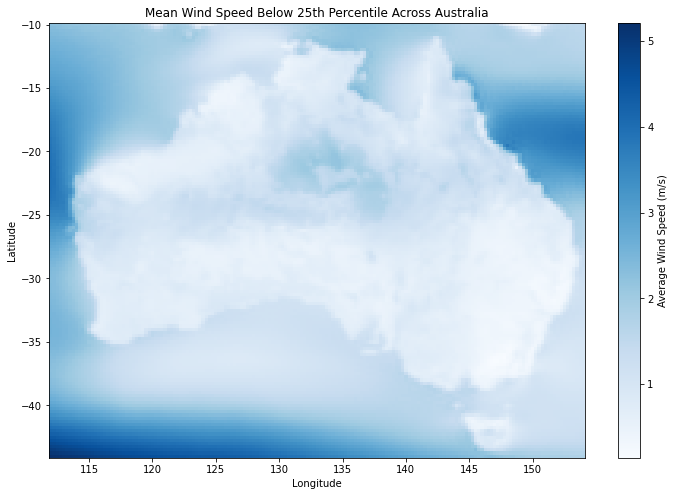

In [16]:
# Plot the mean wind speed values where wind speed is below the 25th percentile
fig, ax = plt.subplots(figsize=(12, 8))
wind_mean_below_25th.plot(ax=ax, cmap='Blues', cbar_kwargs={'label': 'Average Wind Speed (m/s)'})
ax.set_title('Mean Wind Speed Below 25th Percentile Across Australia')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

#### 4.3 average runoff value below 25th percentile

In [17]:
# Calculate the mean runoff values where runoff is below the 25th percentile
runoff_mean_below_25th = runoff_resampled.where(runoff_below_25th).mean(dim='time', skipna=True)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


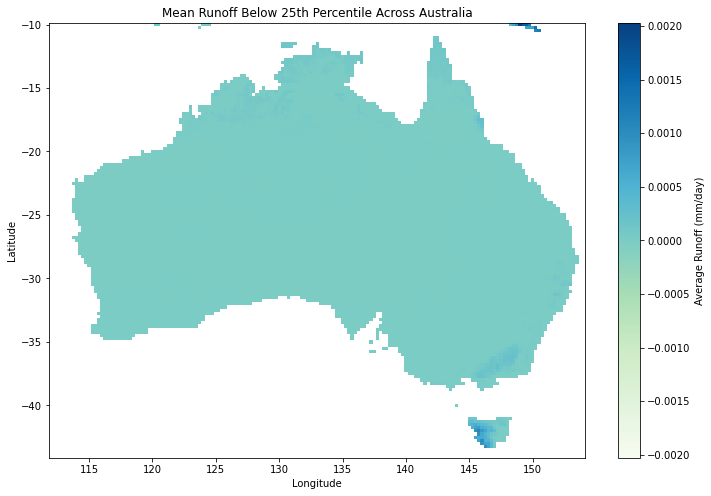

In [18]:
# Plot the mean runoff values where runoff is below the 25th percentile
fig, ax = plt.subplots(figsize=(12, 8))
runoff_mean_below_25th.plot(ax=ax, cmap='GnBu', cbar_kwargs={'label': 'Average Runoff (mm/day)'})
ax.set_title('Mean Runoff Below 25th Percentile Across Australia')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

### Save to NetCDF

In [19]:
output_path = "/g/data/w97/al9345/drought_event_25.nc"

ds.to_netcdf(output_path)
print(f"Boolean data saved to {output_path} successfully.")

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


Boolean data saved to /g/data/w97/al9345/drought_event_25.nc successfully.
